In [1]:
# https://levelup.gitconnected.com/demystifying-python-decorators-726f04963a52
# 
# 

### Plot LOB

In [2]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
from scipy.stats import gamma
np.random.seed(1)

In [3]:
import pickle

In [4]:
def get_step_from_time(d, t):
    for i,v in enumerate(d):
        if float(t) < float(v[0]):
            return i
    return len(d)

In [14]:
def process(fig, ax, history, specific_steps=None, n_bins=10, max_size=50, frame_velocity=150, min_price=0, max_price = 100):
    plot_orders = {
        0: history['limit_orders'],
#         1: history['stop_orders'],
#         2: history['hidden_orders']
    }
    spreads = history['spreads']
    # Check
#     ks1 = [x[0] for x in history['spreads']]
#     ks2 = [x[0] for x in history['limit_orders']]
#     ks3 = [x[0] for x in history['stop_orders']]
#     ks4 = [x[0] for x in history['hidden_orders']]
#     assert(ks1==ks2)
    
    type_orders = {
        0: 'LIMIT', 1: 'STOP', 2: 'HIDDEN'
    }
    plot_animate = {i: {
        'history': None, 'history_prices': None, 'index_spread': None
    } for i in plot_orders}
    patches_for_plot = {}
    
    
    for plot_id in plot_orders:
        orders = plot_orders[plot_id]
        
        # Process
        map_step_time_tmp = {i: str(x[0]) for i,x in enumerate(orders)}
        if specific_steps is None:
            specific_steps = [i for i,_ in enumerate(map_step_time_tmp.items())]
        map_step_time_tmp = {
            k: v for k, v in map_step_time_tmp.items()
                 if k in specific_steps
        }
        plot_animate[plot_id]['map_step_time'] = map_step_time_tmp
        
        # Initialize steps
        n_steps = specific_steps
        orders = [order for i,order in enumerate(orders) if i in specific_steps]
        
        # Get datasets
        # Spreads
        plot_animate[plot_id]['spreads'] = {str(k): v for k,v in spreads}
        # Orders
        orders = {str(k): v for k,v in orders}
        plot_animate[plot_id]['history'] = {}
        min_timestamp = float('inf')
        for timestamp in orders:
            min_timestamp = min(float(timestamp), min_timestamp)
            plot_animate[plot_id]['history'][timestamp] = {'bid': [], 'ask': [], 'all': []}
            for x in orders[timestamp]:
                plot_animate[plot_id]['history'][timestamp]['all'].append(x[1])
                if x[0] == 'Buy':
                    plot_animate[plot_id]['history'][timestamp]['bid'].append(x[1])
                elif x[0] == 'Sell':
                    plot_animate[plot_id]['history'][timestamp]['ask'].append(x[1])
                else:
                    raise Exception()
        # Generate limit bars index
        plot_animate[plot_id]['colors'] = {}
        for timestamp in orders:
            n, bins, intervals = get_n_and_bins(plot_animate[plot_id]['history'][timestamp], n_bins, min_price, max_price)
            n_bars = len(intervals)
            max_bid, min_ask = None, None
            n_green, n_red = 0, 0
            if len(plot_animate[plot_id]['history'][timestamp]['bid']) > 0:
                max_bid = max(plot_animate[plot_id]['history'][timestamp]['bid'])
            if len(plot_animate[plot_id]['history'][timestamp]['ask']) > 0:
                min_ask = min(plot_animate[plot_id]['history'][timestamp]['ask'])
            
            import matplotlib.colors as mcolors
            if max_bid is not None:
                n_green = len([col for col in intervals if col < max_bid])
            if min_ask is not None:
                n_red = len([col for col in intervals if col > min_ask])
            red  = mcolors.to_rgb('r')
            green = mcolors.to_rgb('g')
            c = [green] * (n_green - 1) + [red] * n_red
            plot_animate[plot_id]['colors'][timestamp] = c
        
        # Get initial geometry
        if min_timestamp < float('inf'):
            initial_timestamp = str(min_timestamp)
            verts, codes, left, right, bottom, top = get_verts_codes(plot_animate[plot_id]['history'][initial_timestamp], n_bins, min_price, max_price)
            barpath = path.Path(verts, codes)
            patches_for_plot[plot_id] = patches.PathPatch(barpath, facecolor='green', edgecolor='yellow', alpha=0.5)
        else:
            patches_for_plot[plot_id] = None
    
    def animate(i):
        for plot_id in plot_orders: 
            if patches_for_plot[plot_id] is not None:
                # print(plot_animate[plot_id]['history'].keys())
                
                data = plot_animate[plot_id]['history'][plot_animate[plot_id]['map_step_time'][i]]
                n, bins, _ = get_n_and_bins(data, n_bins, min_price, max_price)
                top = bottom + n
                
                # print("###")
                # print(n)
                # print(bottom)
                # print(top)
                
                verts[1::5, 1] = top
                verts[2::5, 1] = top
                XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T
                pc = matplotlib.collections.PolyCollection(XY, facecolors=plot_animate[plot_id]['colors'][plot_animate[plot_id]['map_step_time'][i]])    

                ax[plot_id].collections = []
                ax[plot_id].add_collection(pc)
                ax[plot_id].set_title('%s ==> (t=%s) (step=%i)' % (type_orders[plot_id], plot_animate[plot_id]['map_step_time'][i], i))

                ax[plot_id].set_xlim(left[0], right[-1])
                ax[plot_id].set_ylim(bottom.min(), max_size)
        # Ret animate
        return []
    # Ret process
    ani = animation.FuncAnimation(fig, animate, n_steps, 
                                  repeat=False, blit=True,
                                  interval=frame_velocity)
    return ani, animate, verts, codes, left, right, bottom, top

In [15]:
# CONTINUE
def get_n_and_bins(data, n, min_price, max_price):
    assert(max_price >= max(data['all']))
    data_modified = [min_price] + data['all'] + [max_price]
    intervals = np.histogram_bin_edges(data_modified, n)
    a, b = np.histogram(data_modified, n)
#     print("###")
#     print(data['all'])
#     print(intervals)
#     print(a)
    return a, b, intervals

def get_verts_codes(data, n_bins, min_price, max_price):
    n, bins, _ = get_n_and_bins(data, n_bins, min_price, max_price)
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n
    nrects = len(left)
    nverts = nrects * (1 + 3 + 1)
    verts = np.zeros((nverts, 2))
    codes = np.ones(nverts, int) * path.Path.LINETO
    codes[0::5] = path.Path.MOVETO
    codes[4::5] = path.Path.CLOSEPOLY
    verts[0::5, 0] = left
    verts[0::5, 1] = bottom
    verts[1::5, 0] = left
    verts[1::5, 1] = top
    verts[2::5, 0] = right
    verts[2::5, 1] = top
    verts[3::5, 0] = right
    verts[3::5, 1] = bottom
    return verts, codes, left, right, bottom, top

20.59


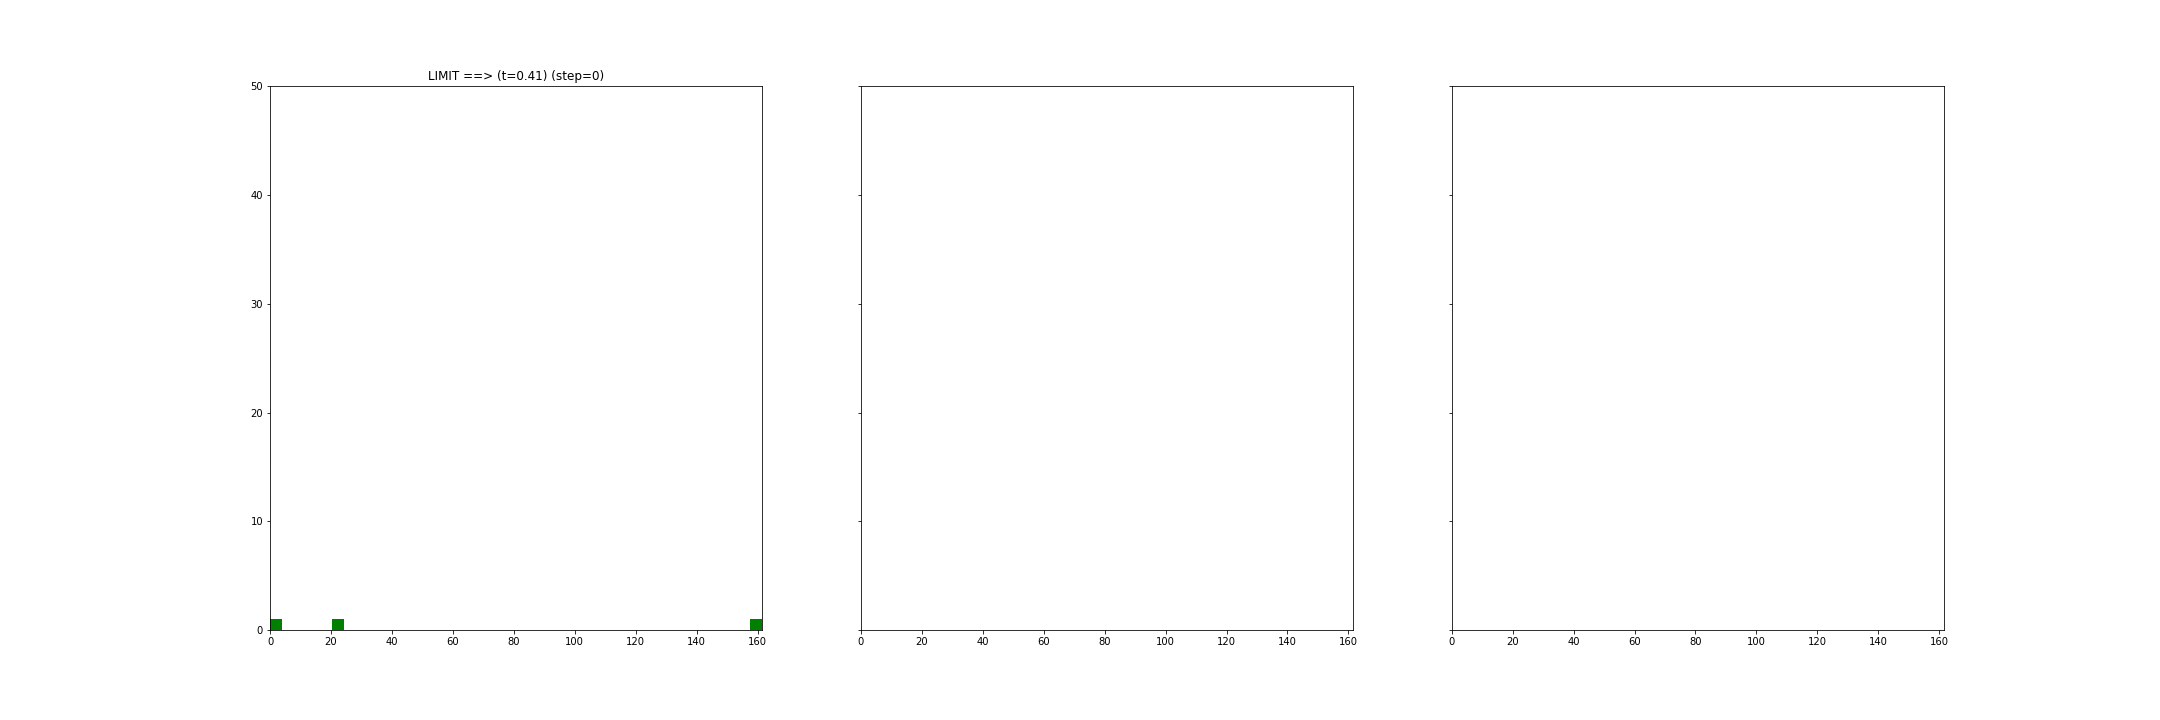

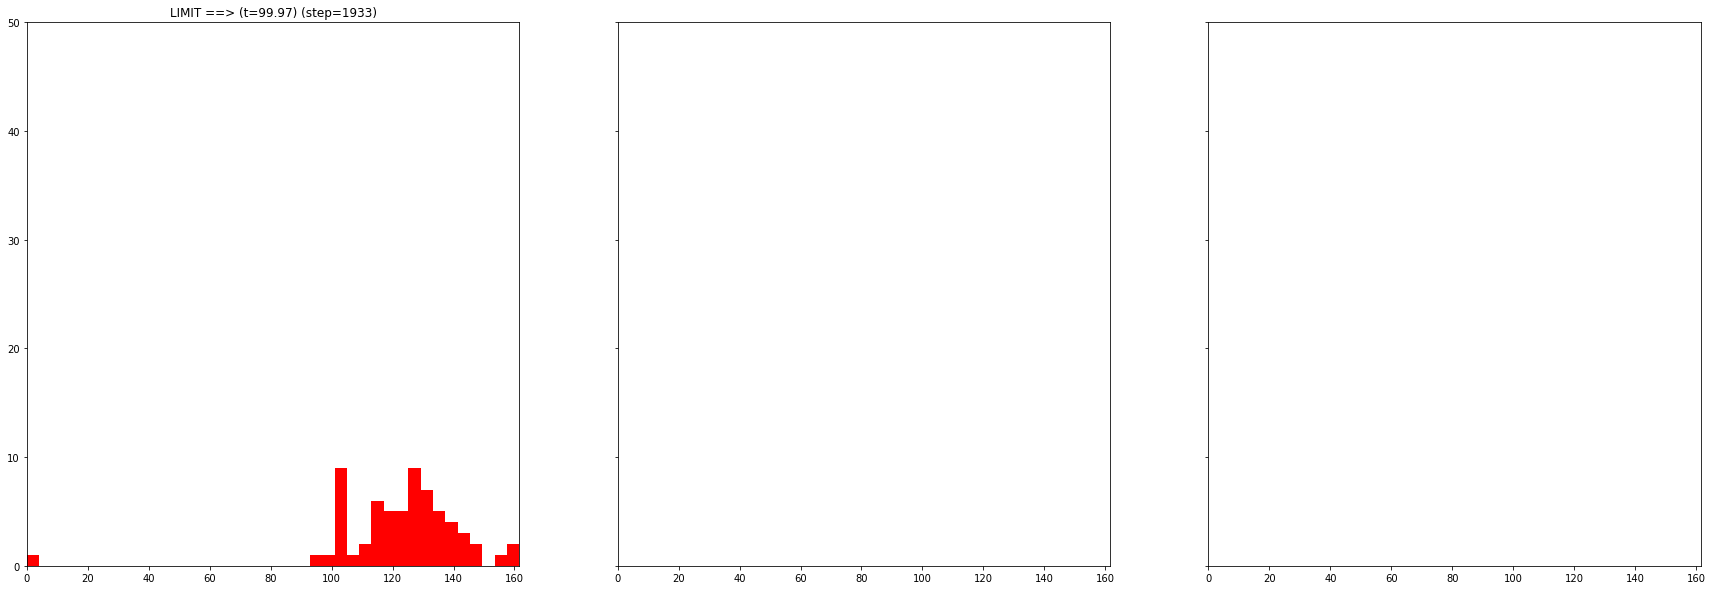

In [16]:
with open('snapshot_history.pkl', 'rb') as f:
    snapshot_history = pickle.load(f)

# Get all orders
all_orders = []
for elem in snapshot_history['limit_orders']:
    for o in elem[1]:
        all_orders.append(o[1])
print(all_orders[0])

# Make plots
n_bins = 40
max_size = 50
frame_velocity=400
min_price, max_price = 0, max(all_orders)
left_time = 0

specific_steps =[int(i) for i in np.linspace(get_step_from_time(snapshot_history['limit_orders'], str(left_time)), 
                                             len(snapshot_history['limit_orders'])-1, 
                                             n_bins)]
# specific_steps = [1830, 1850]
# specific_steps = None

# Plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,10), sharex=True, sharey=True)
ani, animate, verts, codes, left, right, bottom, top = process(fig, ax, snapshot_history, 
                                                               specific_steps, 
                                                               n_bins, 
                                                               max_size, frame_velocity, min_price, max_price)
from IPython.display import Image
x = ani.save('orderbook.gif', writer='imagemagick')
Image(filename="orderbook.gif")

In [47]:
# help(animation.FuncAnimation)

In [63]:
# help(animation.FuncAnimation)
# help( plt.subplots)

In [64]:
# snapshot_history['limit_orders'][13][0]
# get_step_from_time(snapshot_history['limit_orders'], '10')
# specific_steps